# Violence Detection using CNN + LSTM neural network

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
%cd '/content/gdrive/MyDrive/Practice Module/Violence-Detection'
pwd = os.getcwd()
print(pwd)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Practice Module/Violence-Detection
/content/gdrive/MyDrive/Practice Module/Violence-Detection


In [2]:
%matplotlib inline
import cv2
import os
import glob
import random
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation , Dropout


### Load the cached transfer values into memory
We have already saved all the videos transfer values into disk. But we have to load those transfer values into memory in order to train the LSTM net. One question would be: why not process transfer values and load them into RAM memory? Yes is a more eficient way to train the second net. But if you have to train the LSTM in different ways in order to see which way gets the best accuracy, if you didn't save the transfer values into disk you would have to process the whole videos each training. It's very time consuming processing the videos through VGG16 net. 


In order to load the saved transfer values into RAM memory we are going to use this two functions:

In [3]:
def process_data(h5_file):
    
    #joint_transfer=[]
    frames_num=100
    count = 0
    data, target = [], []

    with h5py.File(h5_file, 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        data.append(X_batch[count:inc])
        target.append(y_batch[count])
        count =inc

    data, target = np.array(data), np.array(target)
            
    return data, target

In [4]:
x_train, y_train = process_data('datasets/lstm_keypoints_train.h5')
x_val, y_val = process_data('datasets/lstm_keypoints_test.h5')
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(886, 100, 4096) (222, 100, 4096) (886, 2) (222, 2)


In [5]:
x_test, y_test = process_data('datasets/lstm_keypoints_val.h5')
print(x_test.shape, y_test.shape)

(295, 100, 4096) (295, 2)


## Recurrent Neural Network

### Define LSTM architecture

When defining the LSTM architecture we have to take into account the dimensions of the transfer values. From each frame the VGG16 network obtains as output a vector of 4096 transfer values. From each video we are processing 100 frames so we will have 100 x 4096 values per video. The classification must be done taking into account the 100 frames of the video. If any of them detects violence, the video will be classified as violent.


The first input dimension of LSTM neurons is the temporal dimension, in our case it is 100. The second is the size of the features vector (transfer values).


chunk_size = 4096
n_chunks = 100
rnn_size = 512
model_name = 'model_lstm_opt_flow'

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [6]:
#model.save('lstm_model.h5')
model = load_model('lstm_model.h5')
model_name = 'model_lstm_keypoints'

## Model training


In [7]:

folderpath      = pwd+'/'
filepath        = folderpath + model_name + "_weights.h5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+model_name +'_history.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+model_name+'_history.csv')

Callbacks created:

Path to model: /content/gdrive/MyDrive/Practice Module/Violence-Detection/model_lstm_keypoints_weights.h5
Path to log:   /content/gdrive/MyDrive/Practice Module/Violence-Detection/model_lstm_keypoints_history.csv


In [8]:
epochs = 100
batch_size = 64
verbosity = 2

history = model.fit(x_train, y_train, 
                    epochs=epochs,
                    validation_data=(x_val, y_val), 
                    batch_size=batch_size, 
                    verbose=verbosity,
                    callbacks=callbacks_list)
model.load_weights(filepath)                                                # load the best weights
scores = model.evaluate(x_val, y_val, verbose=1)
print(f'Validation Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

Epoch 1/100
14/14 - 9s - loss: 0.7473 - accuracy: 0.5305 - val_loss: 0.6930 - val_accuracy: 0.5360 - 9s/epoch - 643ms/step
Epoch 2/100
14/14 - 2s - loss: 0.6991 - accuracy: 0.5643 - val_loss: 0.7079 - val_accuracy: 0.5360 - 2s/epoch - 119ms/step
Epoch 3/100
14/14 - 2s - loss: 0.6873 - accuracy: 0.5892 - val_loss: 0.6952 - val_accuracy: 0.5360 - 2s/epoch - 118ms/step
Epoch 4/100
14/14 - 2s - loss: 0.6844 - accuracy: 0.5734 - val_loss: 0.7000 - val_accuracy: 0.5360 - 2s/epoch - 117ms/step
Epoch 5/100
14/14 - 2s - loss: 0.6852 - accuracy: 0.5847 - val_loss: 0.6973 - val_accuracy: 0.5360 - 2s/epoch - 124ms/step
Epoch 6/100
14/14 - 2s - loss: 0.6863 - accuracy: 0.5813 - val_loss: 0.6949 - val_accuracy: 0.5360 - 2s/epoch - 118ms/step
Epoch 7/100
14/14 - 2s - loss: 0.6869 - accuracy: 0.5835 - val_loss: 0.6930 - val_accuracy: 0.5360 - 2s/epoch - 117ms/step
Epoch 8/100
14/14 - 2s - loss: 0.6812 - accuracy: 0.5813 - val_loss: 0.6930 - val_accuracy: 0.5360 - 2s/epoch - 119ms/step
Epoch 9/100
14/1

## Test the model

We are going to test the model with 20 % of the total videos. This videos have not been used to train the network. 

In [9]:
# Evaluate the deep learning model
model.load_weights(filepath)
y_pred = model.predict(np.array(x_test), verbose=0)
print("Confusion matrix :", model_name)
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print('Accuracy  :', accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print('Precision :', precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print('Recall    :', recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

Confusion matrix : model_lstm_keypoints
[[184   0]
 [111   0]]
Accuracy  : 0.6237288135593221
Precision : 0.0
Recall    : 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Confusion matrix : model_lstm_opt_flow
[[184   0]
 [111   0]]
Accuracy  : 0.6237288135593221
Precision : 0.0
Recall    : 0.0

Confusion matrix : model_lstm_keypoints
[[184   0]
 [111   0]]
Accuracy  : 0.6237288135593221
Precision : 0.0
Recall    : 0.0

#### Plot the model accuracy

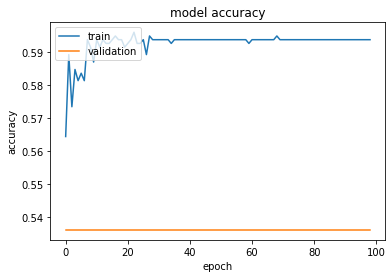

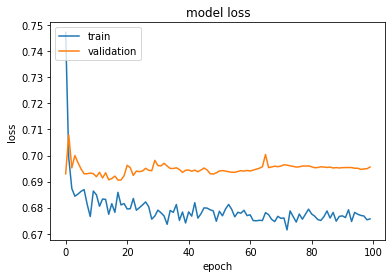

In [10]:
plt.plot(history.history['accuracy'][1:])
plt.plot(history.history['val_accuracy'][1:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('rgb_lstm_acc.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('rgb_lstm_loss.png')
plt.show()

In [ ]:
# import pandas as pd
# df_history = pd.DataFrame(history.history)
# df_history.to_csv('results/model_lstm_opt_flow_history.csv')